## importing neccessary liberaries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import logging

### Load Data

In [2]:
dataset = pd.read_excel("/content/WAR data set.xlsx")

### EDA- Exploratory data analysis

In [3]:
dataset.head()

,Temprature(℃),PH,CaCl₂ (mol/L),Soaking Time (days),Converted Enzyme Conc (g/L),Urea Conc (g/L),Water Absorption reduction (%)
0,35,9.5,0.147273,3,33.944,20.0,15.0
1,25,8.2,0.050909,3,25.458,20.0,8.0
2,30,9.5,0.550000,3,33.944,20.0,22.0
3,30,9.5,0.550000,7,33.944,20.0,27.3
4,30,9.5,0.550000,10,33.944,20.0,28.6


In [4]:
# independent and target variables
X = dataset.drop('Water Absorption reduction (%)', axis = 1)
y = dataset['Water Absorption reduction (%)']

In [5]:
# Normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform (X)
X=pd.DataFrame(X,columns=['Temprature(℃)','PH', 'CaCl₂ (mol/L)', 'Soaking Time (days)', 'Converted Enzyme Conc (g/L)', 'Urea Conc (g/L)	'])
X.head()

,Temprature(℃),PH,CaCl₂ (mol/L),Soaking Time (days),Converted Enzyme Conc (g/L),Urea Conc (g/L)\t
0,0.816466,1.296392,-1.176596,-0.444484,-0.483277,-0.764817
1,-0.524001,0.083290,-1.483405,-0.444484,-1.968972,-0.764817
2,0.146233,1.296392,0.105635,-0.444484,-0.483277,-0.764817
3,0.146233,1.296392,0.105635,0.433599,-0.483277,-0.764817
4,0.146233,1.296392,0.105635,1.092162,-0.483277,-0.764817


In [6]:
# Train _Test Split
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=64)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=64)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Validation set size: {X_val.shape}")

Training set size: (96, 6)
Testing set size: (13, 6)
Validation set size: (12, 6)


In [7]:
def add_noise(data, noise_factor=0.05, num_samples=96, random_state=64):
    augmented_data = []
    np.random.seed(random_state)
    for _ in range(num_samples):
        random_index = np.random.randint(0, len(data))
        sample = data.iloc[random_index]
        noise = np.random.randn(data.shape[1]) * noise_factor
        augmented_sample = sample + noise
        augmented_data.append(augmented_sample)

    augmented_data = pd.DataFrame(augmented_data, columns=data.columns)
    return augmented_data

X_train_augmented = add_noise(X_train, num_samples=96, random_state=64)
y_train_augmented = y_train.iloc[np.random.choice(len(y_train), 96, replace=False)]

X_train_combined = pd.concat([X_train, X_train_augmented], ignore_index=True)
y_train_combined = pd.concat([y_train, y_train_augmented], ignore_index=True)

print(f"Original training set size (Noise Injection): {X_train.shape[0]}")
print(f"Augmented training set size (Noise Injection): {X_train_augmented.shape[0]}")
print(f"Combined training set size (Noise Injection): {X_train_combined.shape[0]}")

print("\nShapes after noise injection augmentation:")
print(f"Shape of X_train_combined: {X_train_combined.shape}")
print(f"Shape of y_train_combined: {y_train_combined.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

Original training set size (Noise Injection): 96
Augmented training set size (Noise Injection): 96
Combined training set size (Noise Injection): 192

Shapes after noise injection augmentation:
Shape of X_train_combined: (192, 6)
Shape of y_train_combined: (192,)
Shape of X_test: (13, 6)
Shape of y_test: (13,)
Shape of X_val: (12, 6)
Shape of y_val: (12,)


In [8]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [9]:
Ada = AdaBoostRegressor(random_state=42)
Ada.fit(X_train_combined, y_train_combined)

AdaBoostRegressor(random_state=42)

In [10]:
Ada.get_params()

{'estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': 42}

In [11]:
y_pred_train = Ada.predict(X_train_combined)
y_pred_test = Ada.predict(X_test)
y_pred_val=Ada.predict(X_val)

In [12]:
from math import sqrt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Evaluate on the training set
print("Training Set Metrics:")
print(f'The RMSE on the training dataset is: {sqrt(mean_squared_error(y_train_combined, Ada.predict(X_train_combined))):.4f}')
print(f'The MSE on the training dataset is: {(mean_squared_error(y_train_combined, Ada.predict(X_train_combined))):.4f}')
print(f'The MAE on the training daset is: {mean_absolute_error(y_train_combined, Ada.predict(X_train_combined)):.4f}')
print(f'The r2_score on the training dataset is: {r2_score(y_train_combined, Ada.predict(X_train_combined)):.4f}')
print("-" * 30)

# Evaluate on the testing set
print("Testing Set Metrics:")
print(f'The RMSE on the testing dataset is: {sqrt(mean_squared_error(y_test, Ada.predict(X_test))):.4f}')
print(f'The MSE on the testing dataset is: {(mean_squared_error(y_test, Ada.predict(X_test))):.4f}')
print(f'The MAE on the testing dataset is: {mean_absolute_error(y_test, Ada.predict(X_test)):.4f}')
print(f'The r2_score on the testing dataset is: {r2_score(y_test, Ada.predict(X_test)):.4f}')
print("-" * 30)

# Evaluate on the validation set
print("Validation Set Metrics:")
print(f'The RMSE on the validation dataset is: {sqrt(mean_squared_error(y_val, Ada.predict(X_val))):.4f}')
print(f'The MSE on the validation dataset is: {(mean_squared_error(y_val, Ada.predict(X_val))):.4f}')
print(f'The MAE on the validation dataset is: {mean_absolute_error(y_val, Ada.predict(X_val)):.4f}')
print(f'The r2_score on the validation dataset is: {r2_score(y_val, Ada.predict(X_val)):.4f}')


Training Set Metrics:
The RMSE on the training dataset is: 8.6042
The MSE on the training dataset is: 74.0318
The MAE on the training daset is: 7.5588
The r2_score on the training dataset is: 0.6543
------------------------------
Testing Set Metrics:
The RMSE on the testing dataset is: 8.3432
The MSE on the testing dataset is: 69.6085
The MAE on the testing dataset is: 7.2556
The r2_score on the testing dataset is: 0.7654
------------------------------
Validation Set Metrics:
The RMSE on the validation dataset is: 10.8075
The MSE on the validation dataset is: 116.8031
The MAE on the validation dataset is: 9.8662
The r2_score on the validation dataset is: 0.6740


### Hyperparameter Tunning (Optimization)]

In [13]:
# Define hyperparameter grid
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


In [14]:
# Perform GridSearchCV to find the best parameters
Ada_grid = GridSearchCV(
    estimator=AdaBoostRegressor(random_state=0),
    param_grid=params,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)


In [15]:
# Define hyperparameter grid
params = {
    'n_estimators': [100, 200, 300],
    'estimator__max_depth': [10, 20, 30, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': ['sqrt', 'log2']
}

# Perform GridSearchCV to find the best parameters
Ada_grid = GridSearchCV(
    estimator=AdaBoostRegressor(random_state=0, estimator=tree.DecisionTreeRegressor(random_state=0)), # Specify the base estimator
    param_grid=params,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)
Ada_grid.fit(X_train_combined, y_train_combined)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(random_state=0),
                                         random_state=0),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [10, 20, 30, None],
                         'estimator__max_features': ['sqrt', 'log2'],
                         'estimator__min_samples_leaf': [1, 2, 4],
                         'estimator__min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [16]:
# Print the best parameters
print("Best Parameters from Grid Search:", Ada_grid.best_params_)

Best Parameters from Grid Search: {'estimator__max_depth': 20, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'n_estimators': 200}


In [17]:
best_Ada = Ada_grid.best_estimator_


In [18]:
y_pred_train = Ada_grid.predict(X_train_combined)
y_pred_test = Ada_grid.predict(X_test)
y_pred_val=Ada_grid.predict(X_val)

In [19]:
# Evaluate on the training set
print("Training Set Metrics:")
print(f'The RMSE on the training dataset is: {sqrt(mean_squared_error(y_train_combined, Ada_grid.predict(X_train_combined))):.4f}')
print(f'The MSE on the training dataset is: {(mean_squared_error(y_train_combined, Ada_grid.predict(X_train_combined))):.4f}')
print(f'The MAE on the training daset is: {mean_absolute_error(y_train_combined, Ada_grid.predict(X_train_combined)):.4f}')
print(f'The r2_score on the training dataset is: {r2_score(y_train_combined , Ada_grid.predict(X_train_combined)):.4f}')
print("-" * 30)

# Evaluate on the testing set
print("Testing Set Metrics:")
print(f'The RMSE on the testing dataset is: {sqrt(mean_squared_error(y_test, Ada_grid.predict(X_test))):.4f}')
print(f'The MSE on the testing dataset is: {(mean_squared_error(y_test, Ada_grid.predict(X_test))):.4f}')
print(f'The MAE on the testing dataset is: {mean_absolute_error(y_test, Ada_grid.predict(X_test)):.4f}')
print(f'The r2_score on the testing dataset is: {r2_score(y_test, Ada_grid.predict(X_test)):.4f}')
print("-" * 30)

# Evaluate on the validation set
print("Validation Set Metrics:")
print(f'The RMSE on the validation dataset is: {sqrt(mean_squared_error(y_val, Ada_grid.predict(X_val))):.4f}')
print(f'The MSE on the validation dataset is: {(mean_squared_error(y_val, Ada_grid.predict(X_val))):.4f}')
print(f'The MAE on the validation dataset is: {mean_absolute_error(y_val, Ada_grid.predict(X_val)):.4f}')
print(f'The r2_score on the validation dataset is: {r2_score(y_val, Ada_grid.predict(X_val)):.4f}')

Training Set Metrics:
The RMSE on the training dataset is: 2.5095
The MSE on the training dataset is: 6.2978
The MAE on the training daset is: 1.6367
The r2_score on the training dataset is: 0.9706
------------------------------
Testing Set Metrics:
The RMSE on the testing dataset is: 3.7406
The MSE on the testing dataset is: 13.9918
The MAE on the testing dataset is: 2.7464
The r2_score on the testing dataset is: 0.9528
------------------------------
Validation Set Metrics:
The RMSE on the validation dataset is: 4.2879
The MSE on the validation dataset is: 18.3857
The MAE on the validation dataset is: 3.4222
The r2_score on the validation dataset is: 0.9487


### Actual vs Predicted Capacity

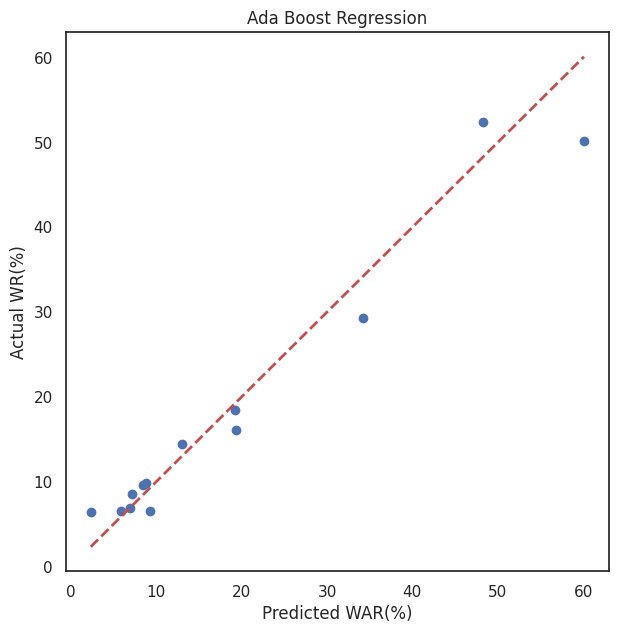

In [20]:
y_predict =best_Ada.predict(X_test)
plt.figure(figsize=(7,7))
sns.set_style('white')
plt.title('Ada Boost Regression')
plt.xlabel("Predicted WAR(%)")
plt.ylabel("Actual WR(%)")
plt.scatter(y_test,y_predict)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.show()

In [21]:
best_Ada.feature_importances_

array([0.17714826, 0.14628066, 0.15030377, 0.1363837 , 0.16818346,
       0.22170015])

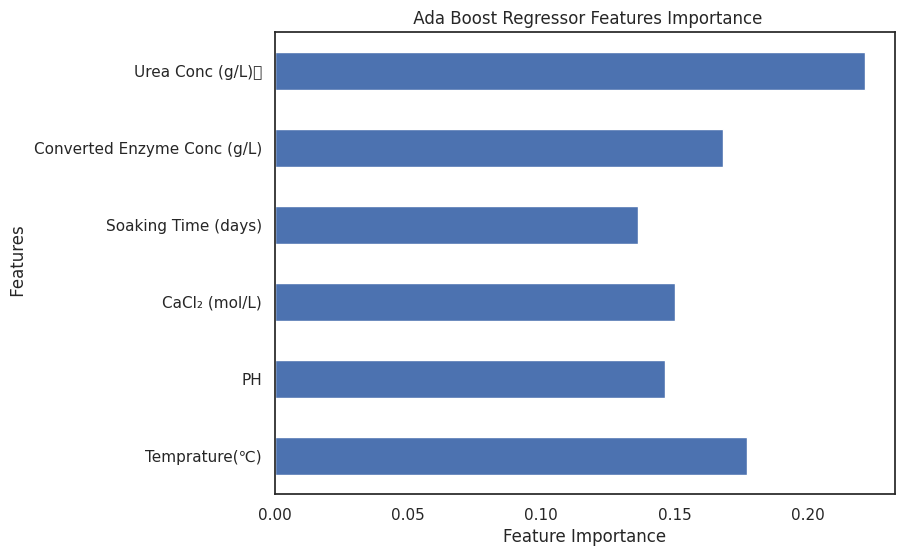

In [22]:
importances = pd.Series(best_Ada.feature_importances_ , index=X.columns)
sns.set_style('white')
importances.plot(kind = 'barh', figsize=(8,6))
plt.xlabel("Feature Importance")
plt.ylabel(" Features")
plt.title(" Ada Boost Regressor Features Importance")
plt.show()

In [27]:
new_data = pd.DataFrame({
    'Temprature(℃)': [25, 25, 25, 25, 25, 25, 25, 25, 25],
    'PH': [7, 7, 7, 7, 7, 7, 7, 7, 7],
    'CaCl₂ (mol/L)': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'Soaking Time (days)': [1, 1, 1, 1, 1, 1, 1, 1, 1],
    'Converted Enzyme Conc (g/L)': [50, 50, 50, 50, 50, 50, 50, 50, 50],
    'Urea Conc (g/L)': [40,40, 40, 40, 40, 40, 40, 40, 40],
    'Water Absorption reduction (%)': [12.4,16.8, 21, 25.8, 34.2, 37.4, 37.3, 37.36, 36.5]
})

display(new_data)

,Temprature(℃),PH,CaCl₂ (mol/L),Soaking Time (days),Converted Enzyme Conc (g/L),Urea Conc (g/L),Water Absorption reduction (%)
0,25,7,0.1,1,50,40,12.40
1,25,7,0.2,1,50,40,16.80
2,25,7,0.3,1,50,40,21.00
3,25,7,0.4,1,50,40,25.80
4,25,7,0.5,1,50,40,34.20
5,25,7,0.6,1,50,40,37.40
6,25,7,0.7,1,50,40,37.30
7,25,7,0.8,1,50,40,37.36
8,25,7,0.9,1,50,40,36.50


In [28]:
# Apply the same scaling to the new data as was applied to the training data
new_data_to_scale = new_data.drop('Water Absorption reduction (%)', axis=1)

# Clean column names to match the scaled training data
new_data_to_scale.columns = new_data_to_scale.columns.str.strip()

new_data_scaled = scaler.transform(new_data_to_scale)
new_data_scaled = pd.DataFrame(new_data_scaled, columns=X.columns)

new_predictions = best_Ada.predict(new_data_scaled)
new_data['Predicted Water Absorption reduction (%)'] = new_predictions
display(new_data)

,Temprature(℃),PH,CaCl₂ (mol/L),Soaking Time (days),Converted Enzyme Conc (g/L),Urea Conc (g/L),Water Absorption reduction (%),Predicted Water Absorption reduction (%)
0,25,7,0.1,1,50,40,12.40,17.600000
1,25,7,0.2,1,50,40,16.80,18.733333
2,25,7,0.3,1,50,40,21.00,21.900000
3,25,7,0.4,1,50,40,25.80,25.775000
4,25,7,0.5,1,50,40,34.20,29.250000
5,25,7,0.6,1,50,40,37.40,34.333333
6,25,7,0.7,1,50,40,37.30,34.850000
7,25,7,0.8,1,50,40,37.36,34.666667
8,25,7,0.9,1,50,40,36.50,34.633333


In [25]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=new_data)

https://docs.google.com/spreadsheets/d/1rKy9q1ztAP13qDCIMquPB1MLXxzpKt1uOMRGn4fyqSY/edit#gid=0


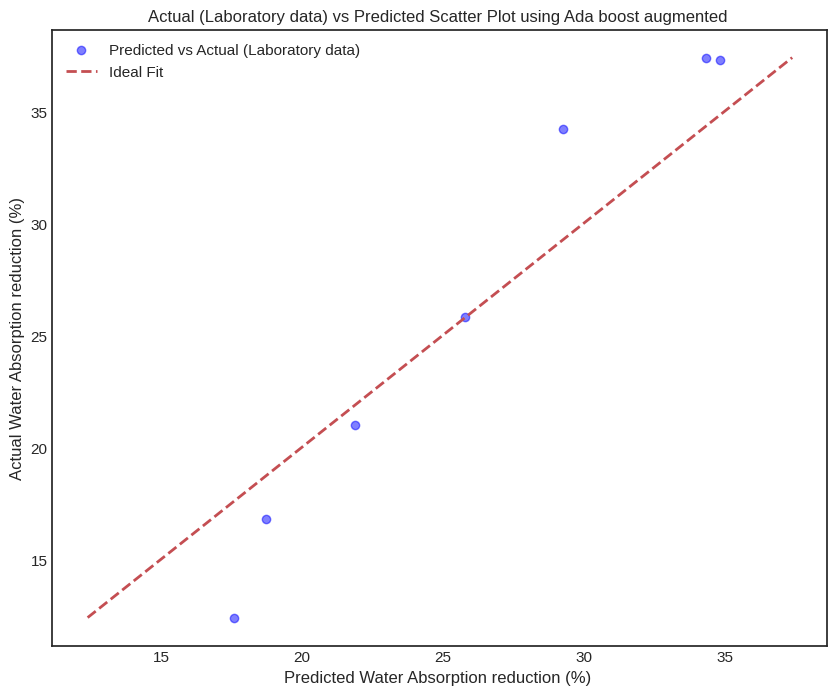

In [26]:
plt.figure(figsize=(10, 8))
plt.style.use('seaborn-v0_8-white')
plt.scatter(new_data['Predicted Water Absorption reduction (%)'], new_data['Water Absorption reduction (%)'], color="blue", alpha=0.5, label="Predicted vs Actual (Laboratory data)")
plt.plot([new_data['Water Absorption reduction (%)'].min(), new_data['Water Absorption reduction (%)'].max()],
         [new_data['Water Absorption reduction (%)'].min(), new_data['Water Absorption reduction (%)'].max()],
         'r--', lw=2, label="Ideal Fit")
plt.xlabel("Predicted Water Absorption reduction (%) ")
plt.ylabel("Actual Water Absorption reduction (%)")
plt.title("Actual (Laboratory data) vs Predicted Scatter Plot using Ada boost augmented ")
plt.legend()
plt.show()